In [56]:
#程式碼取自 博碩, "Python 機器學習", ISBN 978-986-434-140-5, by Sebastian Raschka, 為練習Python函式庫用途
#僅供履歷作品集使用
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [57]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers={key:value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        self.labelnc_ = LabelEncoder()
        self.labelnc_.fit(y)
        self.classes_ = self.labelnc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelnc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
        
        maj_vote = self.labelnc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s_%s' % (name, key)] = value
            return out

In [58]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=1)

In [59]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],['clf', clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1,clf2,pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [60]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels+=['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


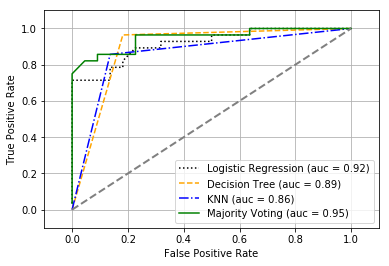

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip (all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

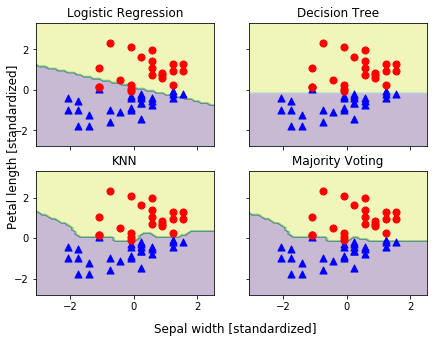

In [62]:
from itertools import product
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max,0.1),np.arange(y_min, y_max,0.1))
f,axarr = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(7,5))
for idx,clf,tt in zip (product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],X_train_std[y_train==0,1], c='blue', marker='^',s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],X_train_std[y_train==1,1], c='red', marker='o',s=50)
    axarr[idx[0],idx[1]].set_title(tt)
plt.text(-3.5,-4.5,s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5,4.5,s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation = 90)
plt.show()

In [63]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier_class_weight': None,
 'decisiontreeclassifier_criterion': 'entropy',
 'decisiontreeclassifier_max_depth': 1,
 'decisiontreeclassifier_max_features': None,
 'decisiontreeclassifier_max_leaf_nodes': None,
 'decisiontreeclassifier_min_impurity_split': 1e-07,
 'decisiontreeclassifier_min_samples_leaf': 1,
 'decisiontreeclassifier_min_samples_split': 2,
 'decisiontreeclassifier_min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier_presort': False,
 'decisiontreeclassifier_random_state': 0,
 'decisiontreeclassifier_splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], 